<a href="https://colab.research.google.com/github/ContiPaolo/Multifidelity-Tutorial/blob/main/MF_POD_Burger's1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creation of the Multilevel dataset

Here we compute for each sample the coarse FEM solution that will then be given as imput to the NN of the fine level

#### Import libraries

In [95]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
#import matplotlib as plt
from matplotlib import pyplot as plt
from itertools import product
import timeit

import pandas as pd 
from keras.optimizers import Adam,Nadam,Adamax
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler
from keras.models import load_model
from sklearn.utils import extmath
from fenics import *

import sys
sys.path.append('../solver')

from model import *

#######################     CONFIGURATIONS     ##########################
np.random.seed(123)
train = True
save = True

### Generation of the coarse-field for each sample

In [82]:
# Resolution parameters
resolution_h1 = (50, 50)
resolution_h2 = (25, 25)
resolution_h3 = (10, 10)

# PDE parameters
field_mean = 1
field_stdev = 1
lamb_cov = 0.1
mkl = 64

# Set up the model(s)
solver_h1 = Model(resolution_h1, field_mean, field_stdev, mkl, lamb_cov)
solver_h2 = Model(resolution_h2, field_mean, field_stdev, mkl, lamb_cov)
solver_h3 = Model(resolution_h3, field_mean, field_stdev, 32, lamb_cov)


# Adjust the trasmissivity based on h1
list1 = solver_h1.solver.mesh.coordinates()
list2 = solver_h2.solver.mesh.coordinates()
list3 = solver_h3.solver.mesh.coordinates()

# Convert lists to numpy arrays if they are not already
array1 = np.array(list1)
array2 = np.array(list2)
array3 = np.array(list3)

# Convert to structured arrays for easy row-wise comparison
dtype = {'names': ['f{}'.format(i) for i in range(array1.shape[1])],
         'formats': [array1.dtype] * array1.shape[1]}

structured_array1 = array1.view(dtype)
structured_array2 = array2.view(dtype)
structured_array3 = array3.view(dtype)

# Create the boolean vector by checking if each row in array1 is in array2
bool_vector2 = np.in1d(structured_array1, structured_array2)
bool_vector3 = np.in1d(structured_array1, structured_array3)

# Set the trasmissivity field
solver_h2.random_process.eigenvalues = solver_h1.random_process.eigenvalues
solver_h2.random_process.eigenvectors = solver_h1.random_process.eigenvectors[bool_vector2]

solver_h3.random_process.eigenvalues = solver_h1.random_process.eigenvalues
solver_h3.random_process.eigenvectors = solver_h1.random_process.eigenvectors[bool_vector3]

2.187679058454625e+20
4.998614104625165e+18
2461.009401194096


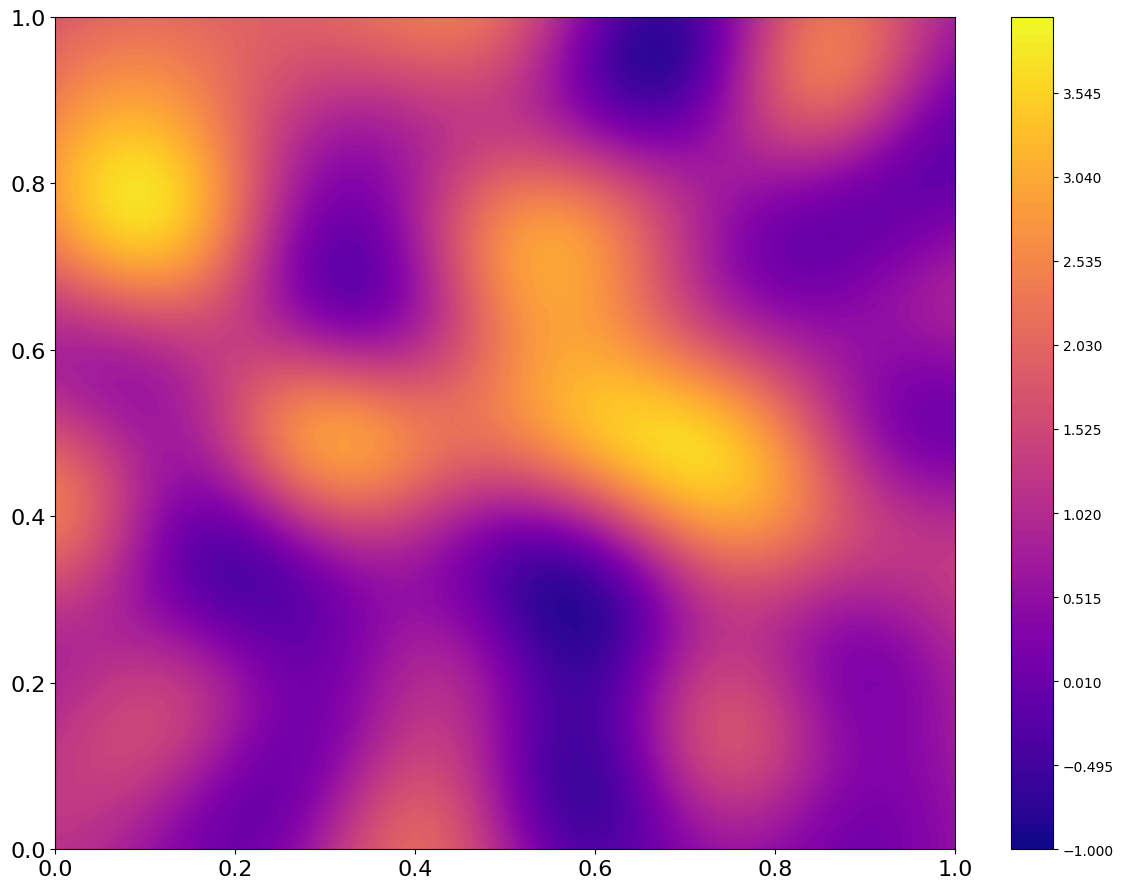

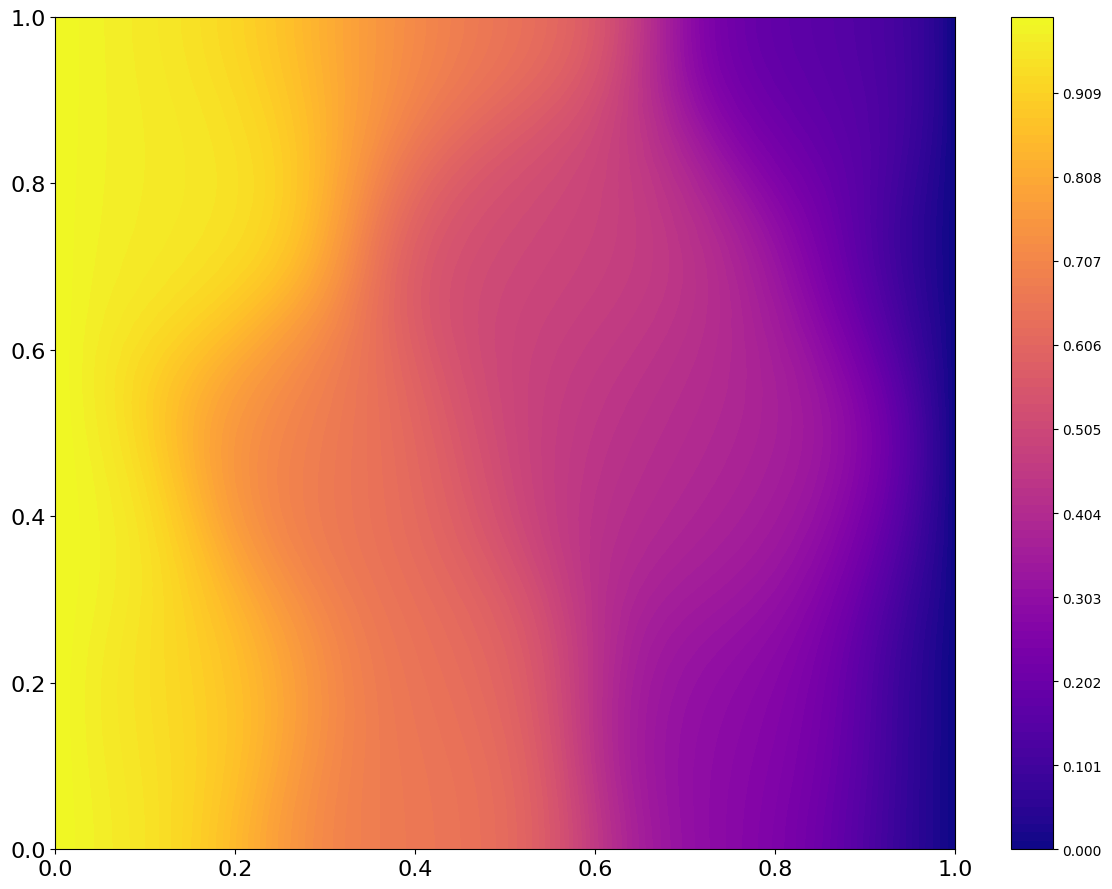

In [83]:
solver_h1.solve(np.ones(64))
solver_h1.plot(limits=[-1,4])

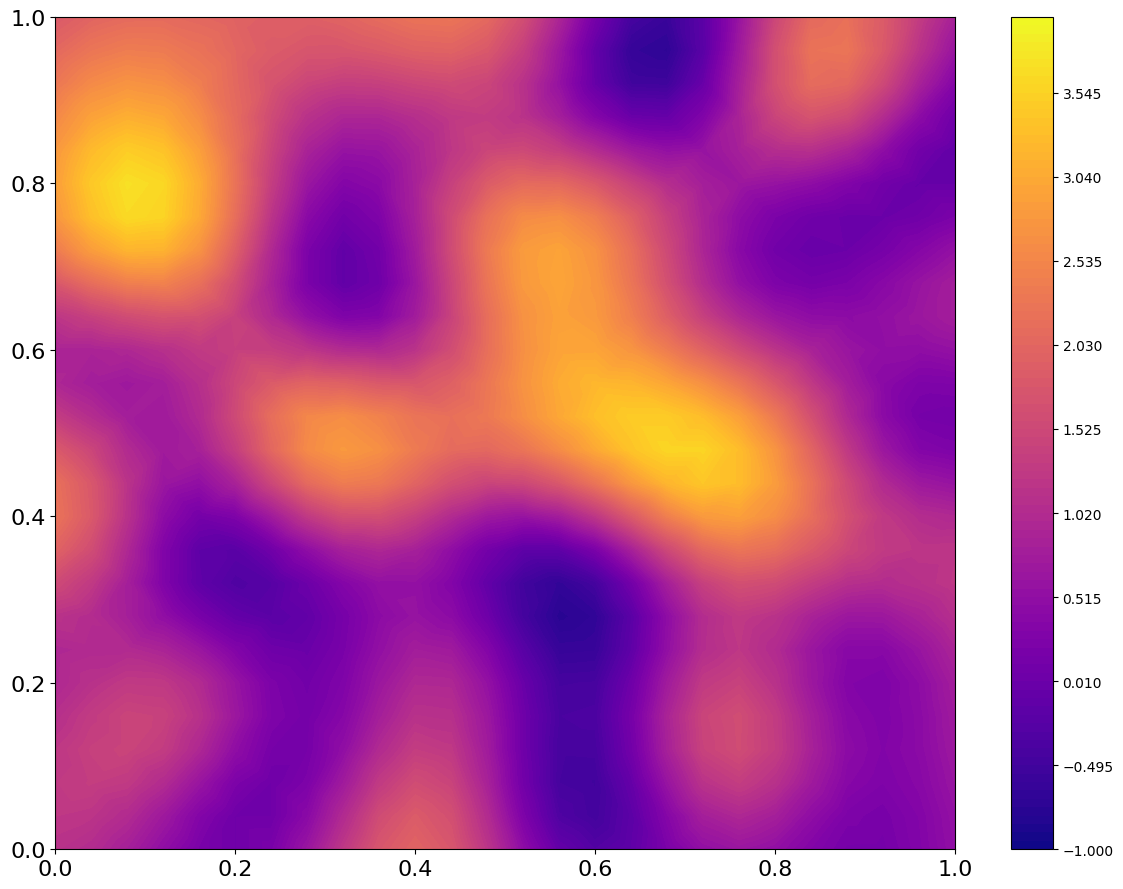

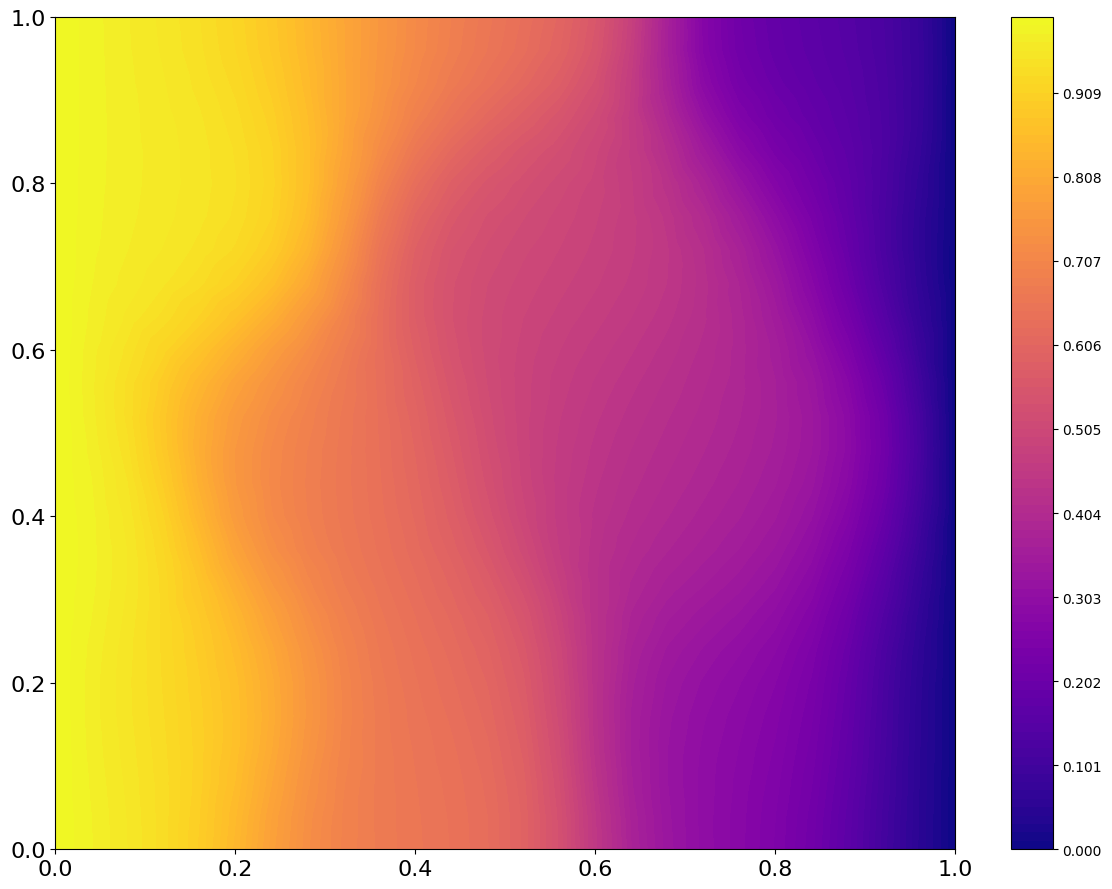

In [84]:
solver_h2.solve(np.ones(64))
solver_h2.plot(limits=[-1,4])

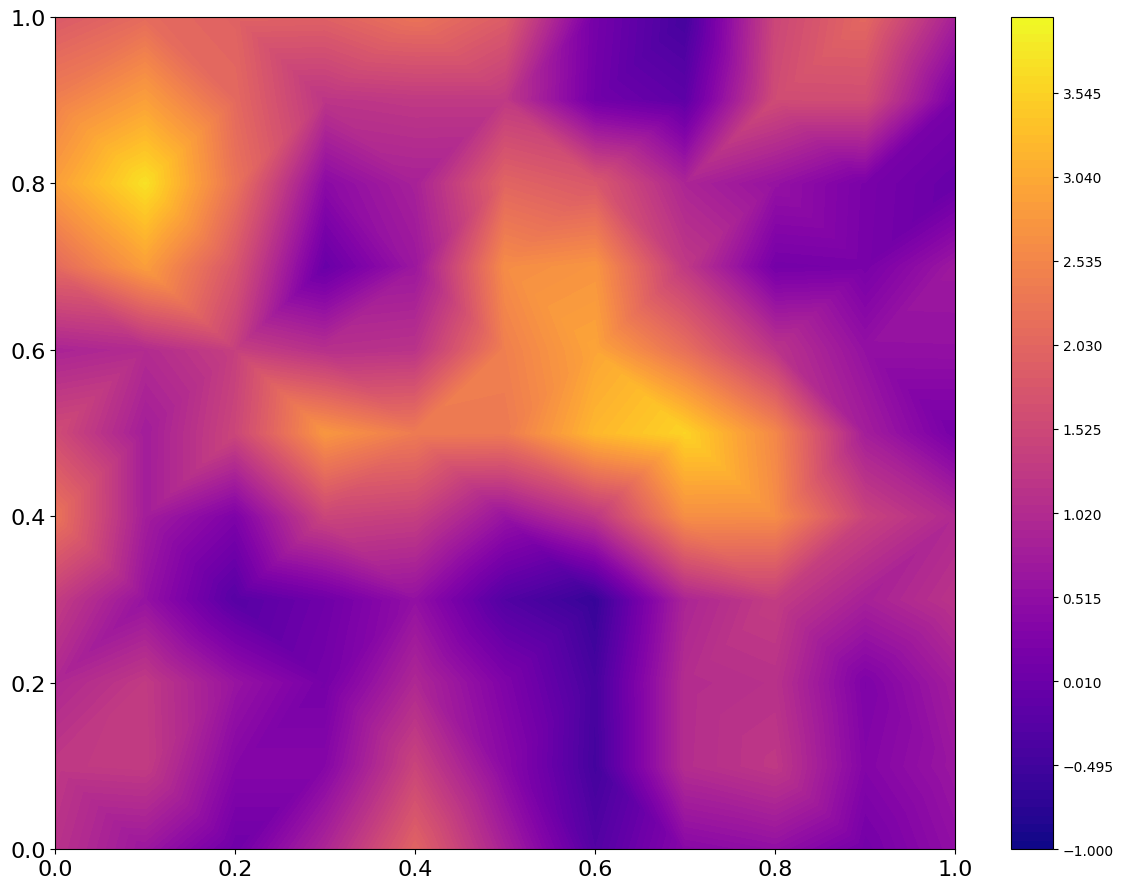

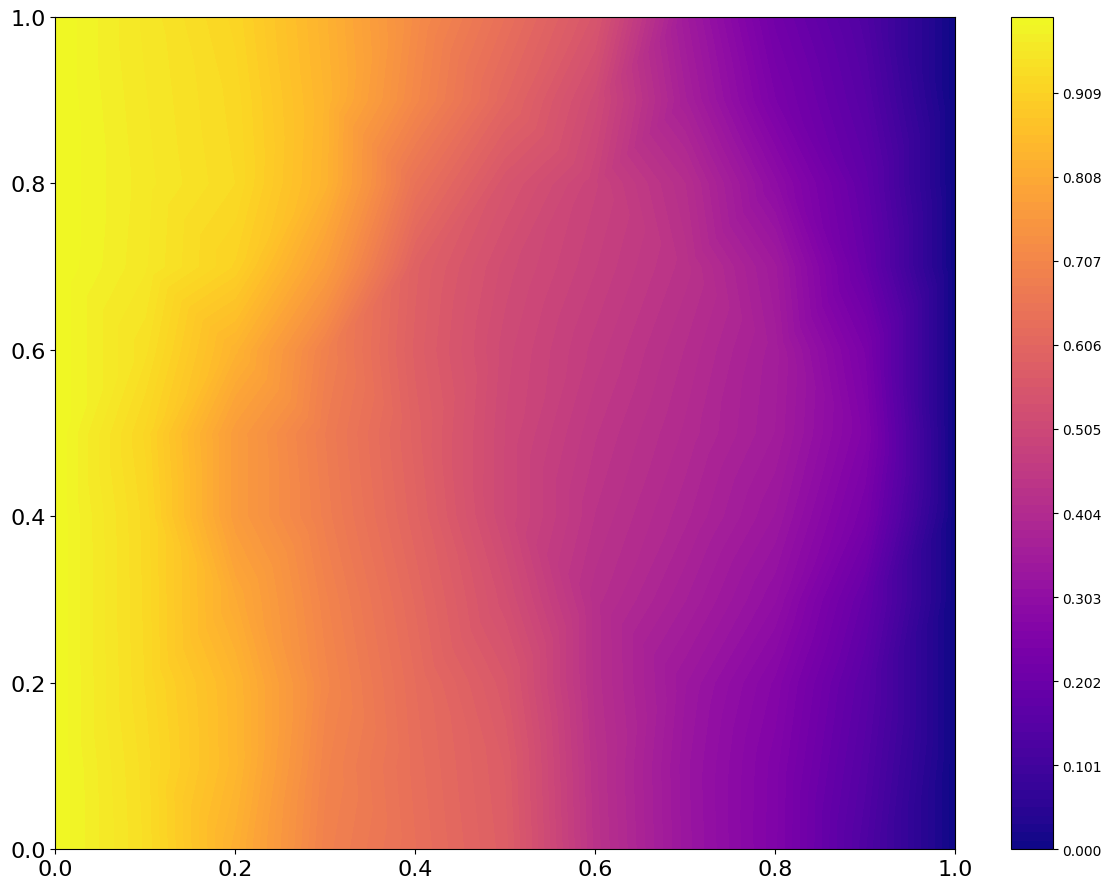

In [85]:
solver_h3.solve(np.ones(64))
solver_h3.plot(limits=[-1,4])

In [86]:
# Collect outputs from each solver
outputs_h1 = solver_h1.get_data(datapoints)
outputs_h2 = solver_h2.get_data(datapoints) for _ in range(num_trials)]
outputs_h3 = [solver_h3.get_data(datapoints) for _ in range(num_trials)]

# Convert lists of outputs to NumPy arrays for easier manipulation
outputs_h1 = np.array(outputs_h1)
outputs_h2 = np.array(outputs_h2)
outputs_h3 = np.array(outputs_h3)

# Calculate mean outputs if necessary or directly use the arrays if they are from varied conditions
# Here we use the arrays directly

# Flatten the arrays if the outputs are multi-dimensional
outputs_h1 = outputs_h1.flatten()
outputs_h2 = outputs_h2.flatten()
outputs_h3 = outputs_h3.flatten()

# Calculate correlation coefficients
correlation_matrix = np.corrcoef([outputs_h1, outputs_h2, outputs_h3])

print("Correlation matrix among three solvers' outputs:")
print(correlation_matrix)

1.5107702973207251e-05
0.00029100641813977076


In [87]:
# Setup
a = np.ones(64)
tot = 1

x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
datapoints = np.array(list(product(x_data, y_data)))
n_datapoints = len(x_data) * len(y_data)

# Define a function for running a solver
def run_solver(solver, a, datapoints):
    solver.solve(a)
    solver.get_data(datapoints)

# Timings using timeit.repeat
time_h1 = np.min(timeit.repeat(lambda: run_solver(solver_h1, a, datapoints), number=1, repeat=5000))
time_h2 = np.min(timeit.repeat(lambda: run_solver(solver_h2, a, datapoints), number=1, repeat=5000))
time_h3 = np.min(timeit.repeat(lambda: run_solver(solver_h3, a, datapoints), number=1, repeat=5000))

# Calculate speedups
speedup2 = time_h1 / time_h2
speedup3 = time_h1 / time_h3

# Display results
print('Average time per run for h1:', time_h1 / tot)
print('Average time per run for h2:', time_h2 / tot)
print('Average time per run for h3:', time_h3 / tot)
print('\nThe speedup coefficients are: h2:', speedup2, "; h3:", speedup3)

Average time per run for h1: 0.008625291986390948
Average time per run for h2: 0.00266566697973758
Average time per run for h3: 0.0018708331044763327

The speedup coefficients are: h2: 3.23569750158366 ; h3: 4.610401625753392


# Back Up

The expected speed up obtained using these three discretization is actually a bit disappointing. This happens becase the number of degrees of freedom is very low, and therefore the asymptotic complexity does not hold. This may be solved using dicretizations 100-50-20, will be replicated to check results. 

In [96]:
# Resolution parameters
resolution_h1 = (100, 100)
resolution_h2 = (50, 50)
resolution_h3 = (20, 20)

# PDE parameters
field_mean = 1
field_stdev = 1
lamb_cov = 0.1
mkl = 64

# Set up the model(s)
solver_h1 = Model(resolution_h1, field_mean, field_stdev, mkl, lamb_cov)
solver_h2 = Model(resolution_h2, field_mean, field_stdev, mkl, lamb_cov)
solver_h3 = Model(resolution_h3, field_mean, field_stdev, 32, lamb_cov)


# Adjust the trasmissivity based on h1
list1 = solver_h1.solver.mesh.coordinates()
list2 = solver_h2.solver.mesh.coordinates()
list3 = solver_h3.solver.mesh.coordinates()

# Convert lists to numpy arrays if they are not already
array1 = np.array(list1)
array2 = np.array(list2)
array3 = np.array(list3)

# Convert to structured arrays for easy row-wise comparison
dtype = {'names': ['f{}'.format(i) for i in range(array1.shape[1])],
         'formats': [array1.dtype] * array1.shape[1]}

structured_array1 = array1.view(dtype)
structured_array2 = array2.view(dtype)
structured_array3 = array3.view(dtype)

# Create the boolean vector by checking if each row in array1 is in array2
bool_vector2 = np.in1d(structured_array1, structured_array2)
bool_vector3 = np.in1d(structured_array1, structured_array3)

# Set the trasmissivity field
solver_h2.random_process.eigenvalues = solver_h1.random_process.eigenvalues
solver_h2.random_process.eigenvectors = solver_h1.random_process.eigenvectors[bool_vector2]

solver_h3.random_process.eigenvalues = solver_h1.random_process.eigenvalues
solver_h3.random_process.eigenvectors = solver_h1.random_process.eigenvectors[bool_vector3]

2.251298741272782e+21
2.187679058454625e+20
327822473709769.3


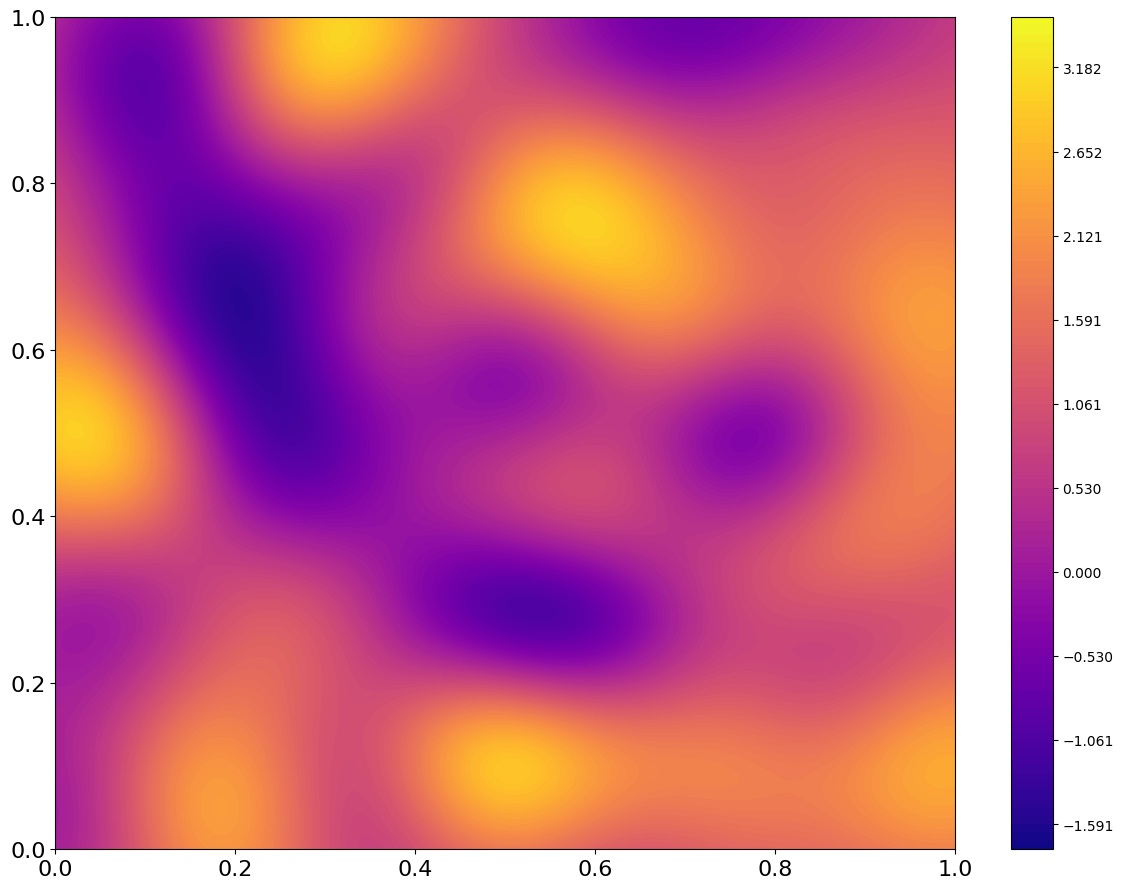

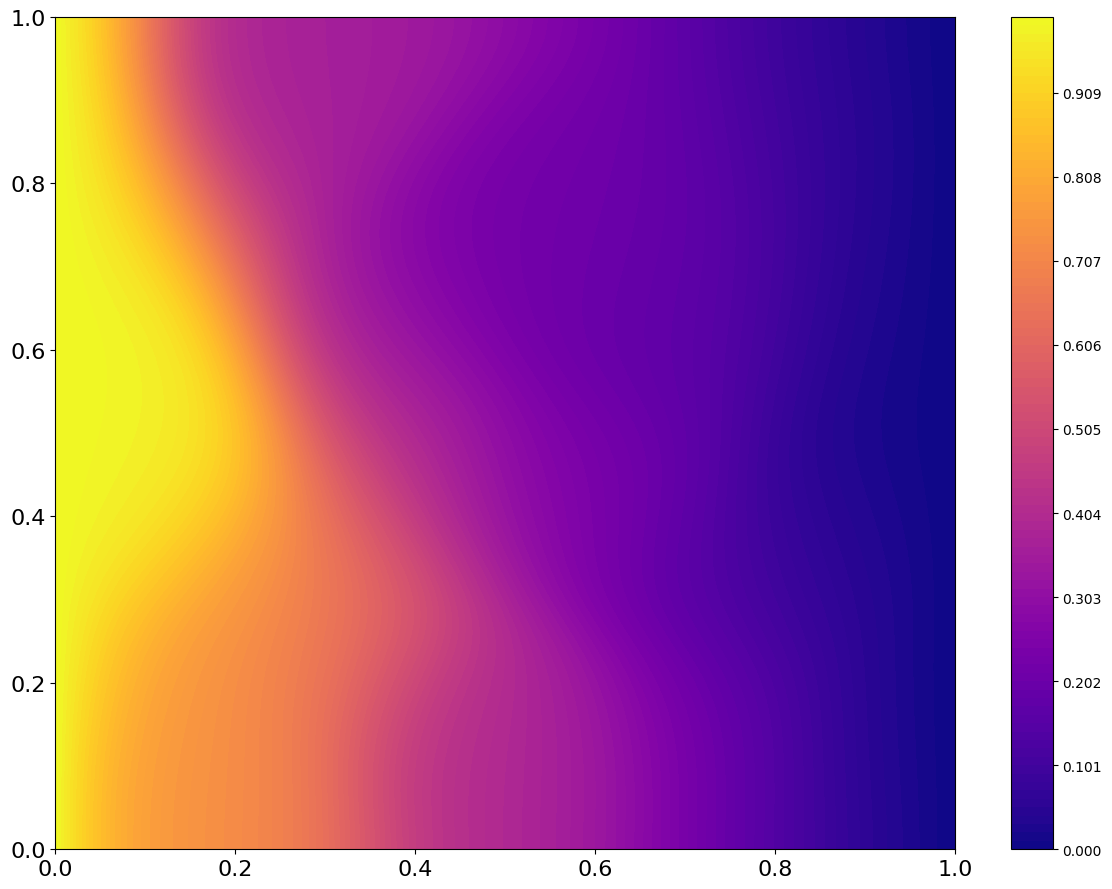

In [89]:
solver_h1.solve(np.ones(64))
solver_h1.plot(limits=[-1.75,3.5])

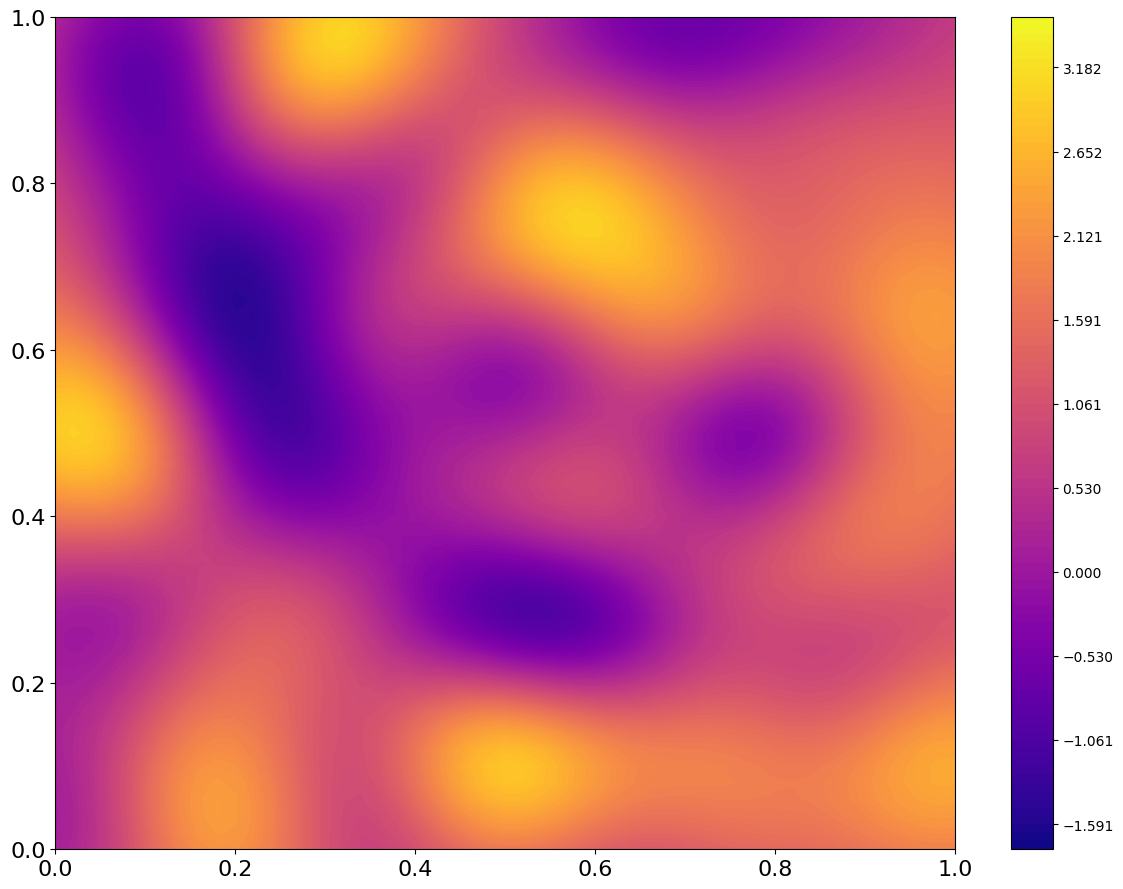

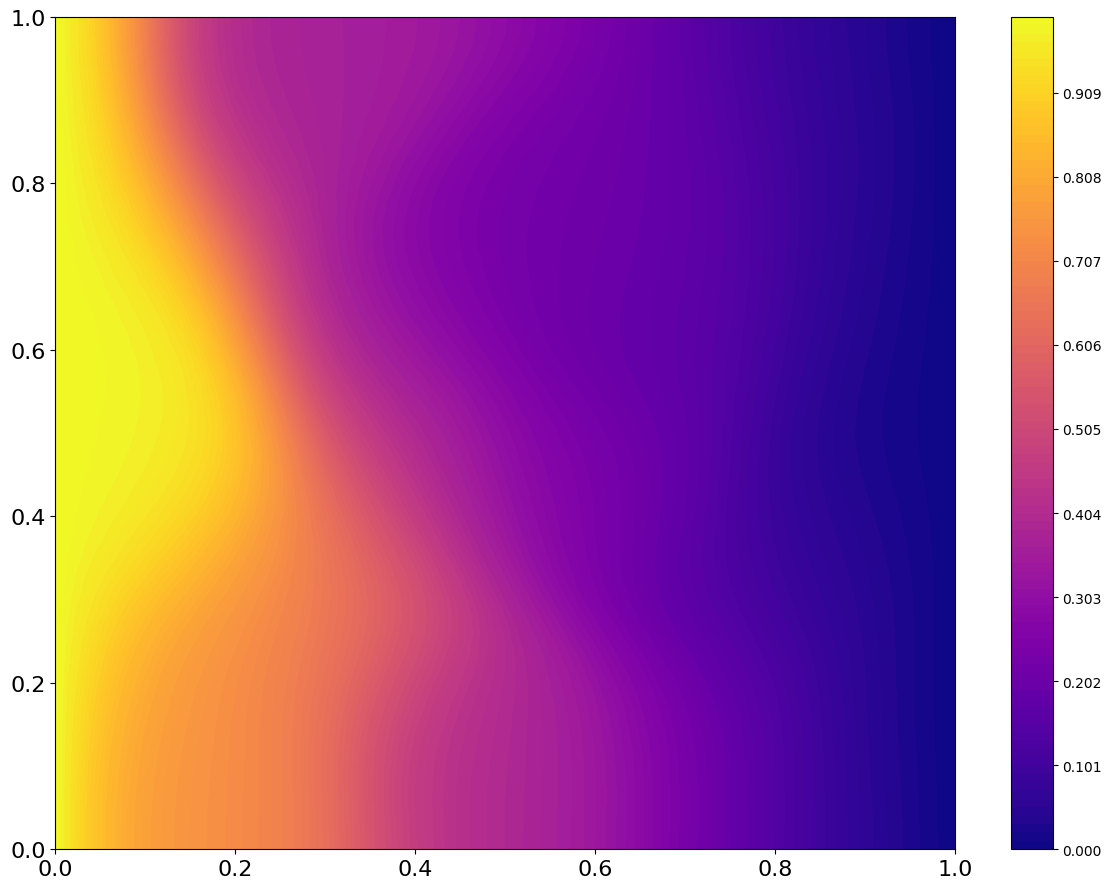

In [90]:
solver_h2.solve(np.ones(64))
solver_h2.plot(limits=[-1.75,3.5])

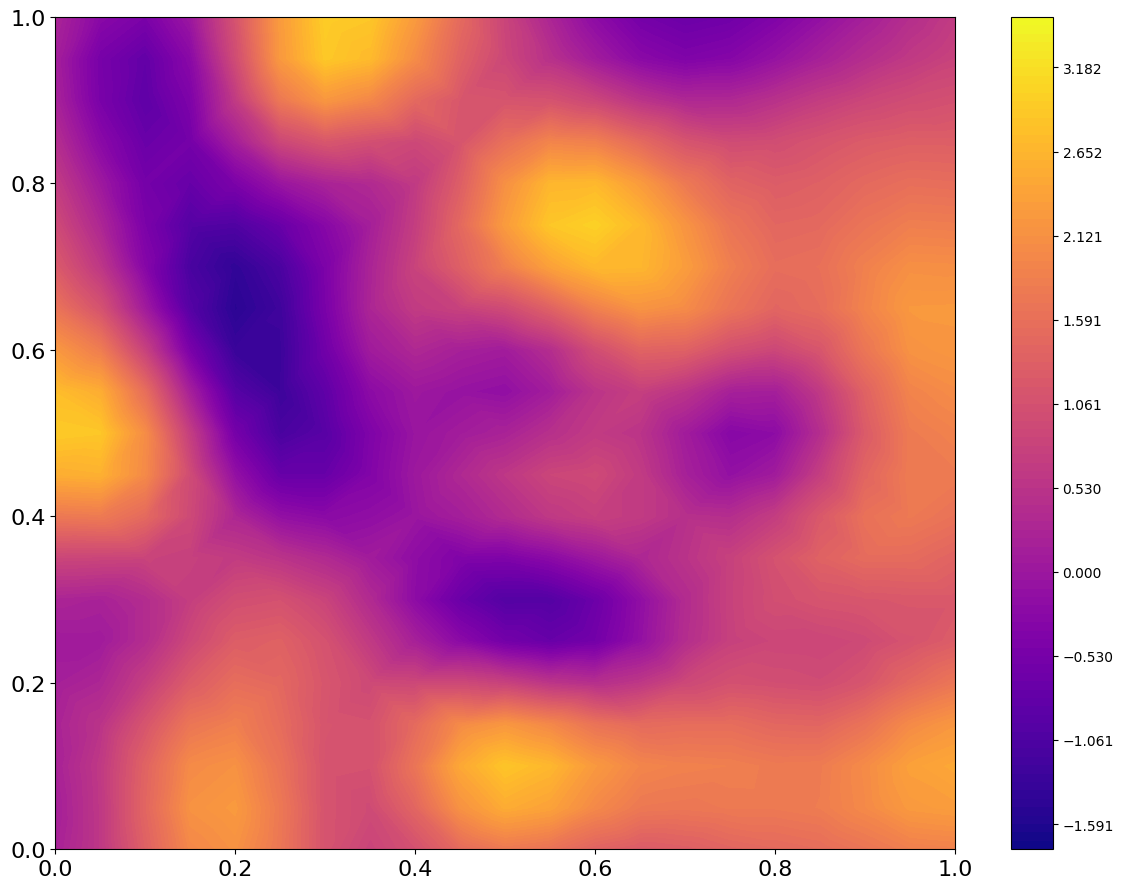

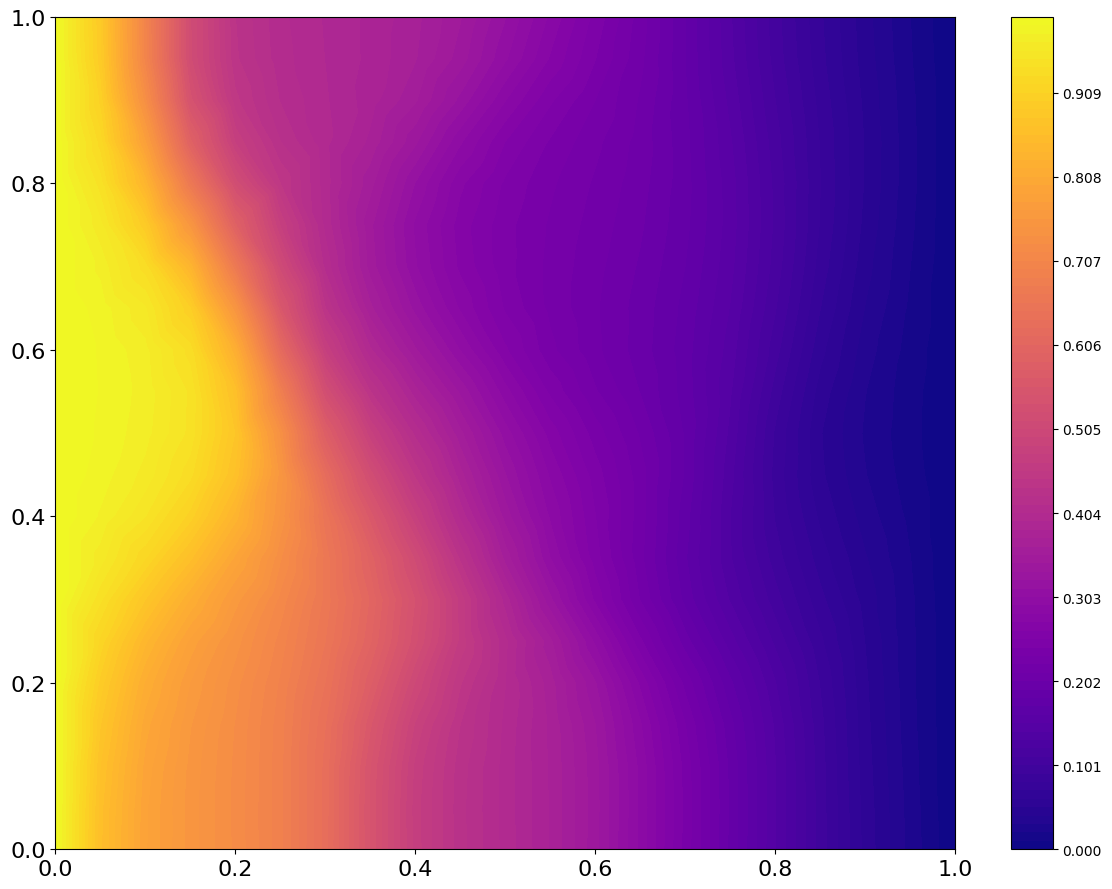

In [91]:
solver_h3.solve(np.ones(64))
solver_h3.plot(limits=[-1.75,3.5])

In [92]:
print(np.mean((solver_h1.get_data(datapoints) - solver_h2.get_data(datapoints))**2))
print(np.mean((solver_h1.get_data(datapoints) - solver_h3.get_data(datapoints))**2))


2.580482847366944e-06
0.0001545752807243061


Note: the plot function of model has been modified using the following code:

In [93]:
# # First plot: Transmissivity Field
# fig1, ax1 = plt.subplots(figsize=(12, 9))  # Adjusted for individual plot size
# ax1.tick_params(labelsize=16)
# field = ax1.tricontourf(self.x, self.y, random_field, levels=contour_levels_field, cmap='plasma')
# fig1.colorbar(field, ax=ax1, orientation='vertical')
# fig1.tight_layout()

# # Second plot: Solution
# fig2, ax2 = plt.subplots(figsize=(12, 9))  # Adjusted for individual plot size
# ax2.tick_params(labelsize=16)
# solution_plot = ax2.tricontourf(self.x, self.y, solution, levels=contour_levels_solution, cmap='plasma')
# fig2.colorbar(solution_plot, ax=ax2, orientation='vertical')
# fig2.tight_layout()

# plt.show()

# Speed UP

In [94]:
# Setup
a = np.ones(64)
tot = 1

x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
datapoints = np.array(list(product(x_data, y_data)))
n_datapoints = len(x_data) * len(y_data)

# Define a function for running a solver
def run_solver(solver, a, datapoints):
    solver.solve(a)
    solver.get_data(datapoints)

# Timings using timeit.repeat
time_h1 = np.min(timeit.repeat(lambda: run_solver(solver_h1, a, datapoints), number=1, repeat=5000))
time_h2 = np.min(timeit.repeat(lambda: run_solver(solver_h2, a, datapoints), number=1, repeat=5000))
time_h3 = np.min(timeit.repeat(lambda: run_solver(solver_h3, a, datapoints), number=1, repeat=5000))

# Calculate speedups
speedup2 = time_h1 / time_h2
speedup3 = time_h1 / time_h3

# Display results
print('Average time per run for h1:', time_h1 / tot)
print('Average time per run for h2:', time_h2 / tot)
print('Average time per run for h3:', time_h3 / tot)
print('\nThe speedup coefficients are: h2:', speedup2, "; h3:", speedup3)

Average time per run for h1: 0.0732767500448972
Average time per run for h2: 0.00900400010868907
Average time per run for h3: 0.002280999906361103

The speedup coefficients are: h2: 8.138244020475236 ; h3: 32.124836936883604
